In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("ml-cls").getOrCreate()

e:\Course\BigData\ClassWOrk\cwenv\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [3]:
df = spark.read.csv("./diabetes.csv",inferSchema=True, header = True)

In [4]:
df.printSchema()

root
 |-- preg: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- bp_diastolic: integer (nullable = true)
 |-- skin_triceps: integer (nullable = true)
 |-- insulin: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- pedigree: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- label: integer (nullable = true)



In [5]:
print((df.count(), len(df.columns)))

(768, 9)


In [6]:
df.filter(df.label==0).count()

500

### data preparation and feature engineering

In [7]:
from pyspark.sql.functions import isnull, when, count, col
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+----+-------+------------+------------+-------+---+--------+---+-----+
|preg|glucose|bp_diastolic|skin_triceps|insulin|bmi|pedigree|age|label|
+----+-------+------------+------------+-------+---+--------+---+-----+
|   0|      0|           0|           0|      0|  0|       0|  0|    0|
+----+-------+------------+------------+-------+---+--------+---+-----+



##  preparation Feature engineering

In [9]:
!pip install seaborn

  Using cached numpy-1.19.5-cp36-cp36m-win_amd64.whl (13.2 MB)
  Using cached pandas-1.1.5-cp36-cp36m-win_amd64.whl (8.7 MB)
  Using cached Pillow-8.4.0-cp36-cp36m-win_amd64.whl (3.2 MB)


In [10]:
import seaborn as sns

<AxesSubplot:>

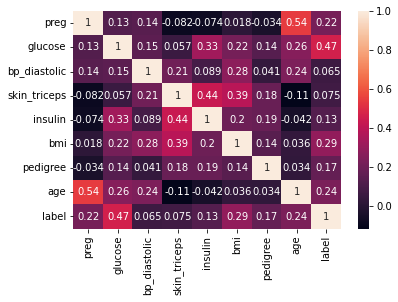

In [11]:
sns.heatmap(df.toPandas().corr(), annot = True)

## Drop unnecessary columns

In [12]:
df = df.drop('skin_triceps')
df = df.drop('bp_diastolic')
df.show(5)

+----+-------+-------+----+--------+---+-----+
|preg|glucose|insulin| bmi|pedigree|age|label|
+----+-------+-------+----+--------+---+-----+
|   6|    148|      0|33.6|   0.627| 50|    1|
|   1|     85|      0|26.6|   0.351| 31|    0|
|   8|    183|      0|23.3|   0.672| 32|    1|
|   1|     89|     94|28.1|   0.167| 21|    0|
|   0|    137|    168|43.1|   2.288| 33|    1|
+----+-------+-------+----+--------+---+-----+
only showing top 5 rows



In [13]:
x = df.drop('label')
x.show()

+----+-------+-------+----+--------+---+
|preg|glucose|insulin| bmi|pedigree|age|
+----+-------+-------+----+--------+---+
|   6|    148|      0|33.6|   0.627| 50|
|   1|     85|      0|26.6|   0.351| 31|
|   8|    183|      0|23.3|   0.672| 32|
|   1|     89|     94|28.1|   0.167| 21|
|   0|    137|    168|43.1|   2.288| 33|
|   5|    116|      0|25.6|   0.201| 30|
|   3|     78|     88|31.0|   0.248| 26|
|  10|    115|      0|35.3|   0.134| 29|
|   2|    197|    543|30.5|   0.158| 53|
|   8|    125|      0| 0.0|   0.232| 54|
|   4|    110|      0|37.6|   0.191| 30|
|  10|    168|      0|38.0|   0.537| 34|
|  10|    139|      0|27.1|   1.441| 57|
|   1|    189|    846|30.1|   0.398| 59|
|   5|    166|    175|25.8|   0.587| 51|
|   7|    100|      0|30.0|   0.484| 32|
|   0|    118|    230|45.8|   0.551| 31|
|   7|    107|      0|29.6|   0.254| 31|
|   1|    103|     83|43.3|   0.183| 33|
|   1|    115|     96|34.6|   0.529| 32|
+----+-------+-------+----+--------+---+
only showing top

## Assemble all the features with VectorAssembler

In [14]:
from pyspark.ml.feature import VectorAssembler

In [16]:
assembler = VectorAssembler(inputCols=x.columns, outputCol='features')
transformed_data = assembler.transform(df)
transformed_data.show(truncate=False)

+----+-------+-------+----+--------+---+-----+---------------------------------+
|preg|glucose|insulin|bmi |pedigree|age|label|features                         |
+----+-------+-------+----+--------+---+-----+---------------------------------+
|6   |148    |0      |33.6|0.627   |50 |1    |[6.0,148.0,0.0,33.6,0.627,50.0]  |
|1   |85     |0      |26.6|0.351   |31 |0    |[1.0,85.0,0.0,26.6,0.351,31.0]   |
|8   |183    |0      |23.3|0.672   |32 |1    |[8.0,183.0,0.0,23.3,0.672,32.0]  |
|1   |89     |94     |28.1|0.167   |21 |0    |[1.0,89.0,94.0,28.1,0.167,21.0]  |
|0   |137    |168    |43.1|2.288   |33 |1    |[0.0,137.0,168.0,43.1,2.288,33.0]|
|5   |116    |0      |25.6|0.201   |30 |0    |[5.0,116.0,0.0,25.6,0.201,30.0]  |
|3   |78     |88     |31.0|0.248   |26 |1    |[3.0,78.0,88.0,31.0,0.248,26.0]  |
|10  |115    |0      |35.3|0.134   |29 |0    |[10.0,115.0,0.0,35.3,0.134,29.0] |
|2   |197    |543    |30.5|0.158   |53 |1    |[2.0,197.0,543.0,30.5,0.158,53.0]|
|8   |125    |0      |0.0 |0

## Machine Learning Data Modal

In [17]:
#split the data
(x_train,x_test) = transformed_data.randomSplit([0.8,0.2])

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier
clf = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3 )

In [19]:
model = clf.fit(x_train)

In [20]:
predictions = model.transform(x_test)
predictions.select('glucose', 'insulin', 'bmi', 'pedigree', 'age', 'label', 'prediction').show(5)

+-------+-------+----+--------+---+-----+----------+
|glucose|insulin| bmi|pedigree|age|label|prediction|
+-------+-------+----+--------+---+-----+----------+
|     57|      0|21.7|   0.735| 67|    0|       0.0|
|     67|      0|45.3|   0.194| 46|    0|       0.0|
|     73|      0|21.1|   0.342| 25|    0|       0.0|
|     74|     36|27.8|   0.269| 22|    0|       0.0|
|     78|     40|36.9|   0.434| 21|    0|       0.0|
+-------+-------+----+--------+---+-----+----------+
only showing top 5 rows



In [21]:
predictions.select('glucose', 'insulin', 'bmi', 'pedigree', 'age', 'label', 'prediction').show()

+-------+-------+----+--------+---+-----+----------+
|glucose|insulin| bmi|pedigree|age|label|prediction|
+-------+-------+----+--------+---+-----+----------+
|     57|      0|21.7|   0.735| 67|    0|       0.0|
|     67|      0|45.3|   0.194| 46|    0|       0.0|
|     73|      0|21.1|   0.342| 25|    0|       0.0|
|     74|     36|27.8|   0.269| 22|    0|       0.0|
|     78|     40|36.9|   0.434| 21|    0|       0.0|
|     84|     66|35.8|   0.545| 21|    0|       0.0|
|     84|    125|38.2|   0.233| 23|    0|       0.0|
|     95|    105|44.6|   0.366| 22|    0|       0.0|
|     97|    100|36.8|     0.6| 25|    0|       0.0|
|     99|      0|25.0|   0.253| 22|    0|       0.0|
|    101|      0|21.9|   0.336| 25|    0|       0.0|
|    101|      0|24.6|   0.237| 22|    0|       0.0|
|    106|    148|39.4|   0.605| 22|    0|       0.0|
|    107|      0|26.4|   0.133| 23|    0|       0.0|
|    111|      0|24.6|    0.66| 31|    0|       0.0|
|    117|      0|33.8|   0.932| 44|    0|     

In [22]:
predictions.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   25|
|    0|       0.0|  107|
|    1|       1.0|   21|
|    0|       1.0|   11|
+-----+----------+-----+



In [23]:
# calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()

In [25]:
accuracy = (TN + TP) / (TN + TP + FN +FP)
precision = TP / (TP + FP)
recall = TP/ (TP + FN)

print('n accuracy: %0.3f' % accuracy)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)

n accuracy: 0.780
n precision: 0.656
n recall: 0.457


###  model evalution

In [26]:
y_true = predictions.select('label').rdd.flatMap(list).collect()
y_pred = predictions.select('prediction').rdd.flatMap(list).collect()

In [27]:
len(y_pred)

164

In [29]:
!pip install scikit-learn

In [31]:
from sklearn import metrics

In [32]:
cm = metrics.confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[107  11]
 [ 25  21]]


In [33]:
import matplotlib.pyplot as plt

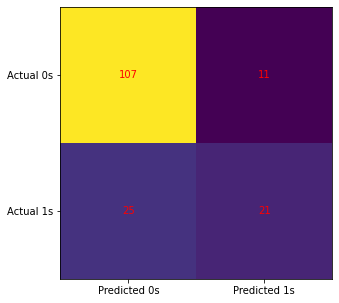

In [34]:
fig , ax = plt.subplots(figsize=(5,5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j], ha='center', va='center', color='red')
plt.show()